# Introduction to Quantum Computation
# Solutions to Problem Set 5  

Applied Mathematics and Computer Science  
Presented by: Oscar Velasco  
Presented to: Julián Jiménez  
Date: 30/Nov/2020

In [1]:
# Necessary Libraries

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
import math
import cmath
import random
import numpy as np

%matplotlib inline

The qiskit version used to this task is:

In [2]:
qiskit.__version__

'0.15.2'

In [3]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.1'}

--------------------------------------------------------------------------------------------

# Problem 1 [P]

**Quantum Fourier Transform**. Keep the following points in mind:

**a)** Construct a generic quantum circuit that can deal with and arbitrary number of  qubits $n \geq 1$. 

**b)** Make sure the implemented circuit runs correctly on a local classical computer with up to five qubits before running it on a real device.

**c)** Run the above quantum code on a real quantum computer with $n = 3$ qubits; check your results.

**d)** ***Important***: Comment every relevant step of the implementation. Do not just write code without explaining what is going on. 

## Solution (a)

Consider the Quantum Fourier Transform circuit represented in the following graphic taken from the section 3.7 of the digital book ***Learn Quantum Computation Using Qiskit*** [1]:

<img src = "qft.png">

Where the gates after the fourth barrier represent a swap between the respective qubits.
Given the above, consider the following implementation of a quantum circuit that executes the Quantum Fourier Transform over a state of $n$ qubits and later executes the Inverse Quantum Fourier Transform to verify the correct operation of the transformed: 

In [4]:
# Define a recursive function that applies the respective gates (Hadamart and Rotations) 
# in the line k that represent the k-th qubit, later do k += 1 until reaching the last 
# qubit in the quantum circuit (k = n)
def qft_rotations(qc, n, k):
    if k == n: # Exit function if circuit is empty
        return qc
    qc.h(k)
    for qubit in range(1, n - k):
        qc.cu1(np.pi / (2 ** qubit), qubit + k, k)
    k += 1
    qc.barrier()
    qft_rotations(qc,n,k)

In [5]:
# And now, define a funtion that makes the respective swaps after performing the rotations
def swap_registers(qc, n):
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

In [6]:
# In this way, we can define the Quantum Fourier Transform
def QFT(qc, n):
    # Apply the Hadamart and Rotations gates in every qubit
    qft_rotations(qc, n, 0)
    # Apply the final swaps in the quantum circuit
    swap_registers(qc, n)
    return qc

Now, consider the following implementation of the Inverse Quantum Fourier Transform. Remember that this consists of reversing the order in which the quantum gates are applied in the Quantum Fourier Transform, taking into account that the rotations are made in the opposite direction:  

In [7]:
# Define the Inverse Quantum Fourier Transform
def QFT_Inv(qc, n):
    qft_qc = QFT(QuantumCircuit(n), n)
    # Take the inverse of the above circuit (Qiskit is cool)
    inv_qft_qc = qft_qc.inverse()
    # qc.append(inv_qft_qc, qc.qubits[:n])
    qc = qc + inv_qft_qc
    return qc

Finally, consider the following function that implement a circuit in which the Quantum Fourier Transform is applied to a given quantum state represented by $n$ qubits and the apply the Inverse Quantum Fourier Transform. Theoretically, we should return to the initial quantum state already mentioned:

In [8]:
# General circuit for n >= 1 qubits
def all_qc(ini_state):
    # Where ini_state is the initial quantum state represented by n qubits (as a String)
    n = len(ini_state)
    qc = QuantumCircuit(n)
    for i in range(n):
        if(ini_state[i] == '1'):
            qc.x(-i-1)
    qc.barrier()        
    # Apply the Quantum Fourier Transform
    qc = QFT(qc, n)
    qc.barrier()
    qc.barrier()
    qc.barrier()
    # Apply the Inverse Quantum Fourier Transform
    qc = QFT_Inv(qc, n)
    # Take all the measurement
    qc.measure_all()
    return qc

$$$$

## Solution (b)

Let's try the previous implementation for $n = 6$ qubits on a classical computer, taking the initial state as the number $42$, which binary representation is $101010$. So, note that:

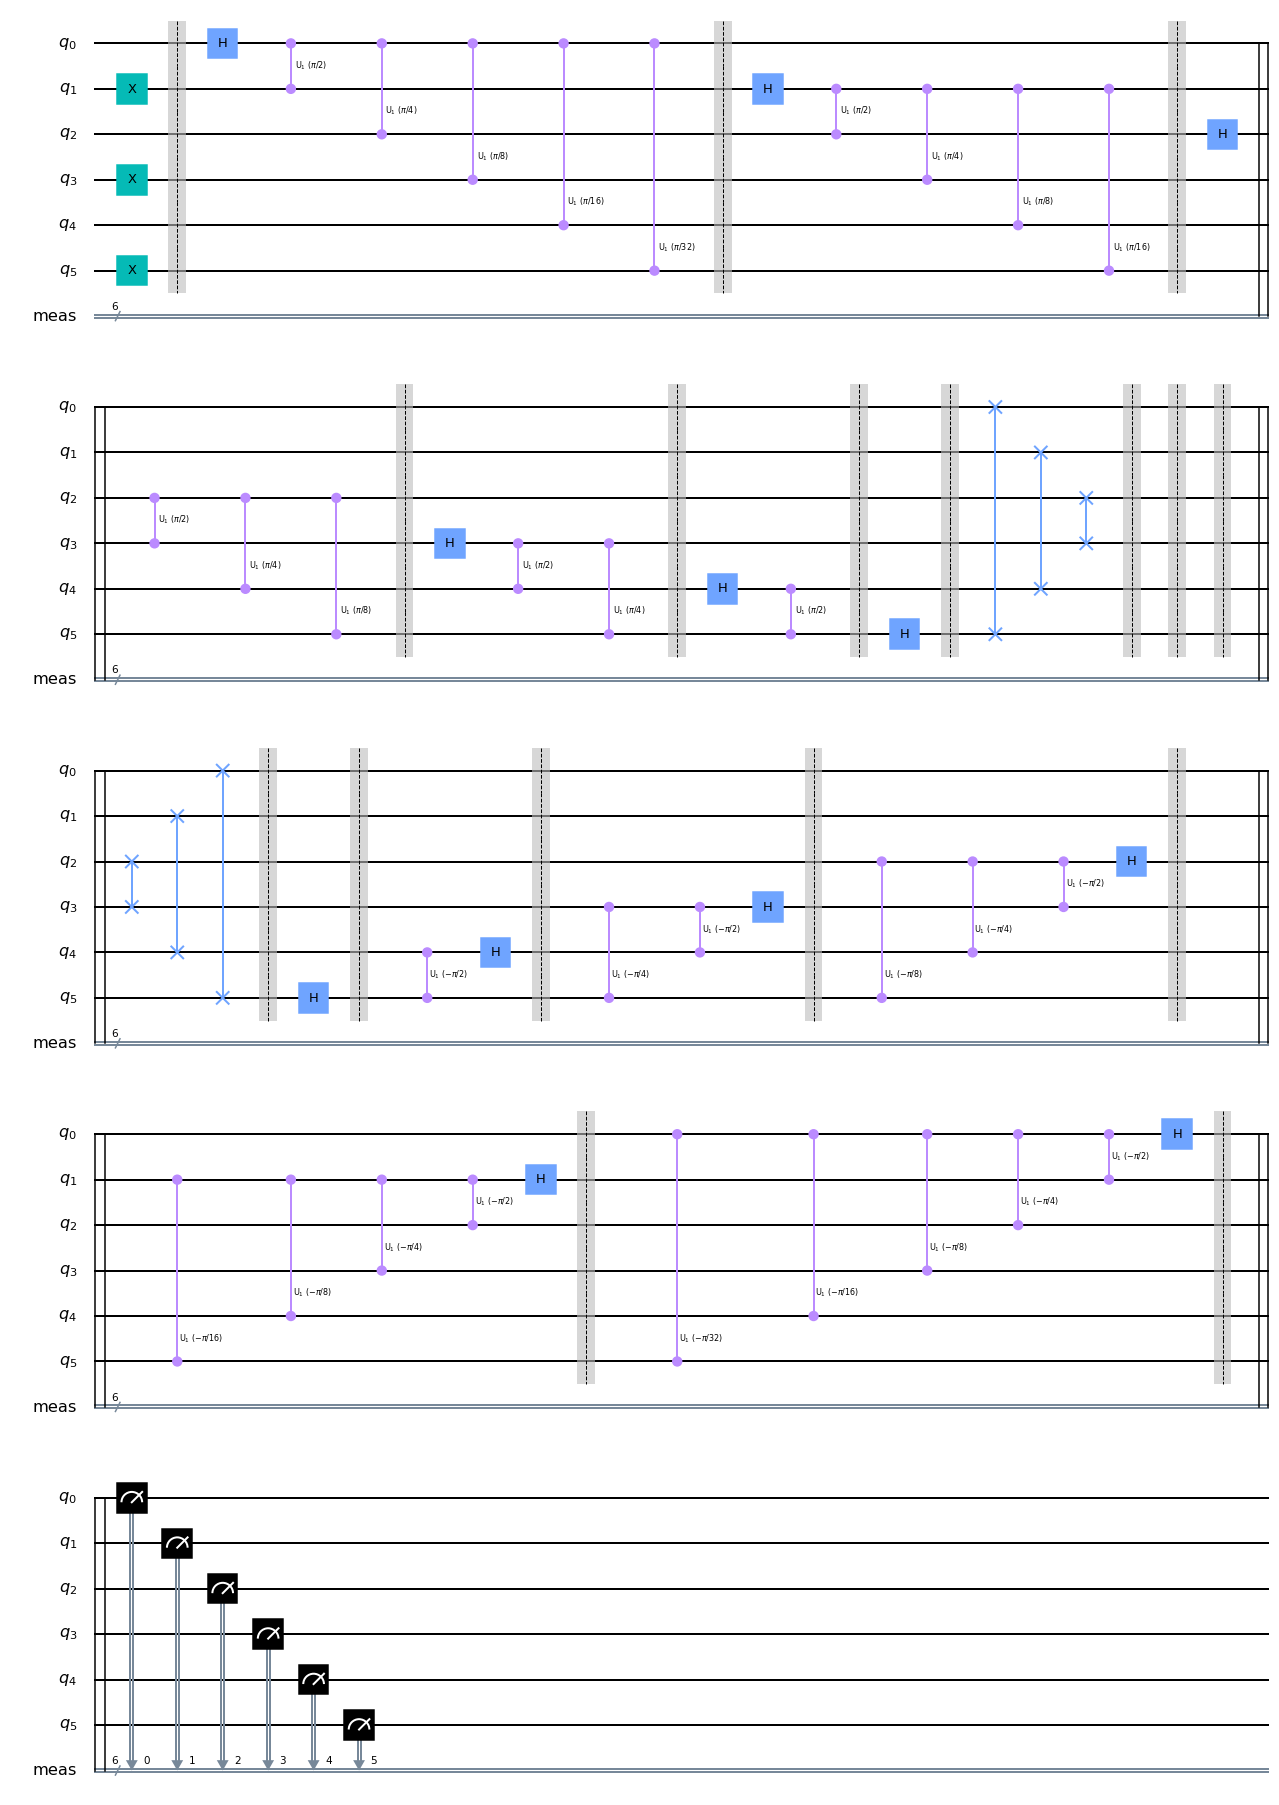

In [9]:
ini_state1 = '101010' # 42
qc1 = all_qc(ini_state1)
qc1.draw('mpl')

Remember that, Quantum Fourier Transform is applied before the triple barrier and after it Inverse Quantum Fourier Transform is applied.

Now, observe the following graphic:

{'101010': 1024}


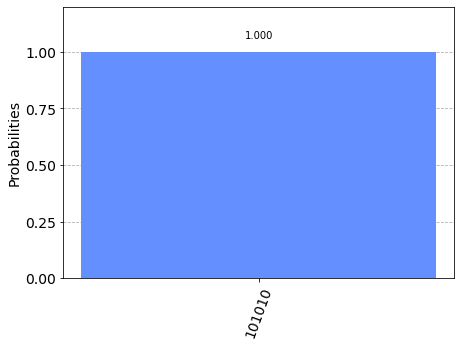

In [10]:
# Execute the implementation on a classical computer
backend1 = Aer.get_backend('qasm_simulator')
job_sim1 = execute(qc1, backend1, shots = 1024)
sim_result1 = job_sim1.result()

# Histogram of probabilities
meas_result1 = sim_result1.get_counts(qc1)
print(meas_result1)
plot_histogram(meas_result1)

Note that, we effectively return to the initial quantum state, and with this the implementation is verified.

$$$$

## Solution (c)

Now, we are going to execute the above implementation on a real quantum computer, with $n = 3$ qubits, taking the initial state as the number $5$, which binary representation is $101$. So, note that:

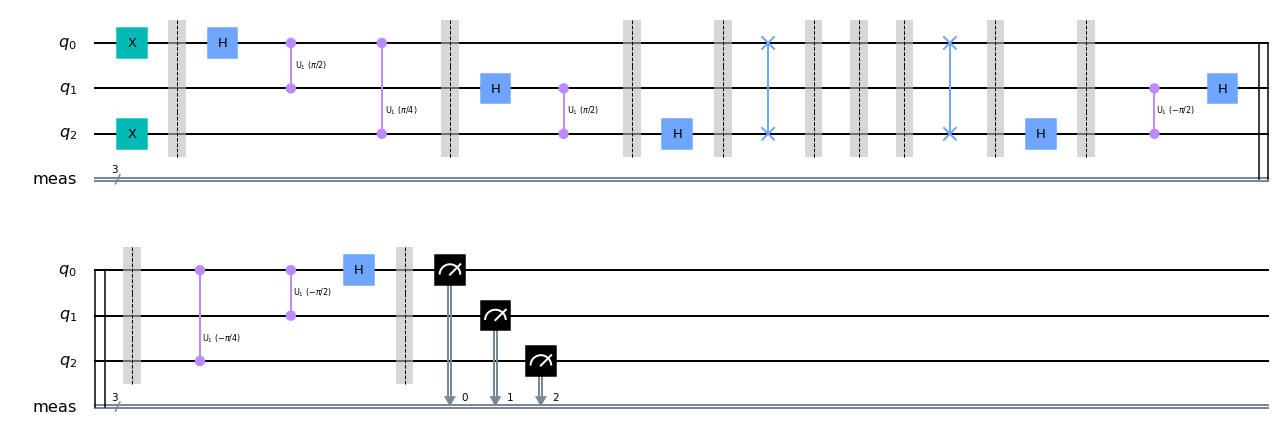

In [11]:
ini_state2 = '101' # 5
n2 = len(ini_state2)
qc2 = all_qc(ini_state2)
qc2.draw('mpl')

In [12]:
IBMQ.save_account('4333ba0445a2dec45dd7d7ad62e0ae3e18587682cc7557212a3c89863593d0572de405cf0b3b857109c4c08040133caf268c7815d6d6f7d2e036a8d67385c97d')

configrc.store_credentials:WARNING:2020-11-30 19:56:49,267: Credentials already present. Set overwrite=True to overwrite.


In [14]:
# Load our IBMQ account
IBMQ.load_account()

# Reserve the resources to run our implementation
provider = IBMQ.get_provider(hub = 'ibm-q')
backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= n2 
                                       and not b.configuration().simulator 
                                       and b.status().operational == True))
print("least busy backend: ", backend)

# Run our implementation on a real quantum computer
job_exp = execute(qc2, backend = backend, shots = 8192)

# Queue in IBM quantum computers
job_monitor(job_exp)

ibmqfactory.load_account:WARNING:2020-11-30 19:57:52,710: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_athens
Job Status: job has successfully run


{'000': 446, '001': 947, '010': 116, '011': 185, '100': 917, '101': 4925, '110': 249, '111': 407}


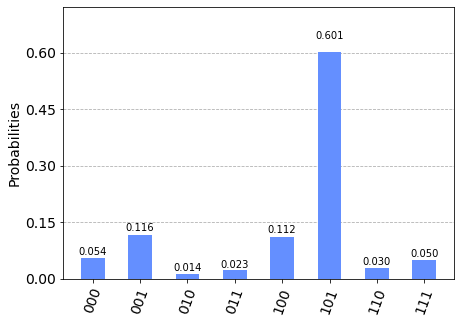

In [15]:
# Results simulation on real quantum computer 
exp_result = job_exp.result()
exp_meas_res = exp_result.get_counts(qc2)
print(exp_meas_res)

# Histogram of probabilities
plot_histogram(exp_meas_res)

Finally, note that the results given by the quantum computer have more separate probabilities, but even so, the larger of these agree with the initial quantum state that we define.

--------------------------------------------------------------------------------------------

## Bibliography  

[1] **Learn Quantum Computation Using Qiskit**.  

**Contributors**: Abraham Asfaw, Luciano Bello, Yael Ben-Haim, Sergey Bravyi, Lauren Capelluto, Almudena Carrera Vazquez, Jack Ceroni, Richard Chen, Albert Frisch, Jay Gambetta, Shelly Garion, Leron Gil, Salvador De La Puente Gonzalez, Francis Harkins, Takashi Imamichi, David McKay, Antonio Mezzacapo, Zlatko Minev, Ramis Movassagh, Giacomo Nannicni, Paul Nation, Anna Phan, Marco Pistoia, Arthur Rattew, Joachim Schaefer, Javad Shabani, John Smolin, Kristan Temme, Madeleine Tod, Stephen Wood, James Wootton.  

**Link**: https://qiskit.org/textbook/preface.html  

[2]  **Quantum Computation and Quantum Information**, 10th Edition, Michael A. Nielsen & Isaac L. Chuang, 2010, Cambridge University Press.